<h1><b>Importing Requried Libraries

In [1]:
import matplotlib.pyplot as plt, numpy as np, tensorflow as tf, PIL

In [2]:
tf.__version__

'2.15.0'

<h1><b>Loading Dataset

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
print(f"X_train Shape: {X_train.shape}\nX_test Shape{X_test.shape}")

X_train Shape: (60000, 28, 28)
X_test Shape(10000, 28, 28)


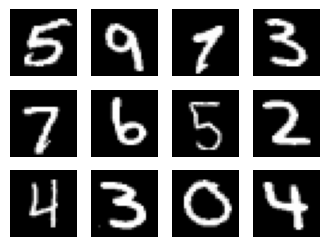

In [5]:
plt.figure(figsize=(4, 4))
for i in range(12):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i+20000].reshape(28, 28), cmap='gray')
    plt.axis('off')

# plt.tight_layout()
plt.show()

In [6]:
def process_data(imgs):
  return np.where(imgs > .5, 1.0, 0.0).astype('float32')

X_train = process_data(X_train)
X_test = process_data(X_test)

X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)) / 255.
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)) / 255.

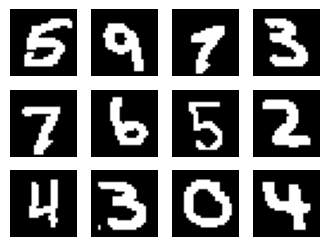

In [7]:
plt.figure(figsize=(4, 4))
for i in range(12):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i+20000].reshape(28, 28), cmap='gray')
    plt.axis('off')

# plt.tight_layout()
plt.show()

<h1><b>Defining Models

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda
from tensorflow.keras.models import Model, Sequential
from keras import backend as K

img_shape = (28, 28, 1)
latent_dim = 2
batch_size = 16

<h2>Encoder

In [9]:
input_img = Input(shape=img_shape)

x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)


<h2>Sampling Function: To take vector from the distribution defined by meand and log(variance)

In [10]:

def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mu, z_log_sigma])

In [11]:
z.shape

TensorShape([None, 2])

In [12]:
import numpy as np

<h2>Decoder

In [13]:
decoder_input = Input(K.int_shape(z)[1:])

x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

x = Reshape(shape_before_flattening[1:])(x)

x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

<h2>Loss Function: Reconstruction Loss + KL Divergence

In [15]:
import keras
from tensorflow.keras import metrics

class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded, z_mu, z_log_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + 0.01*kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_log_sigma = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_mu, z_log_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded, z_mu, z_log_sigma])


In [16]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                            

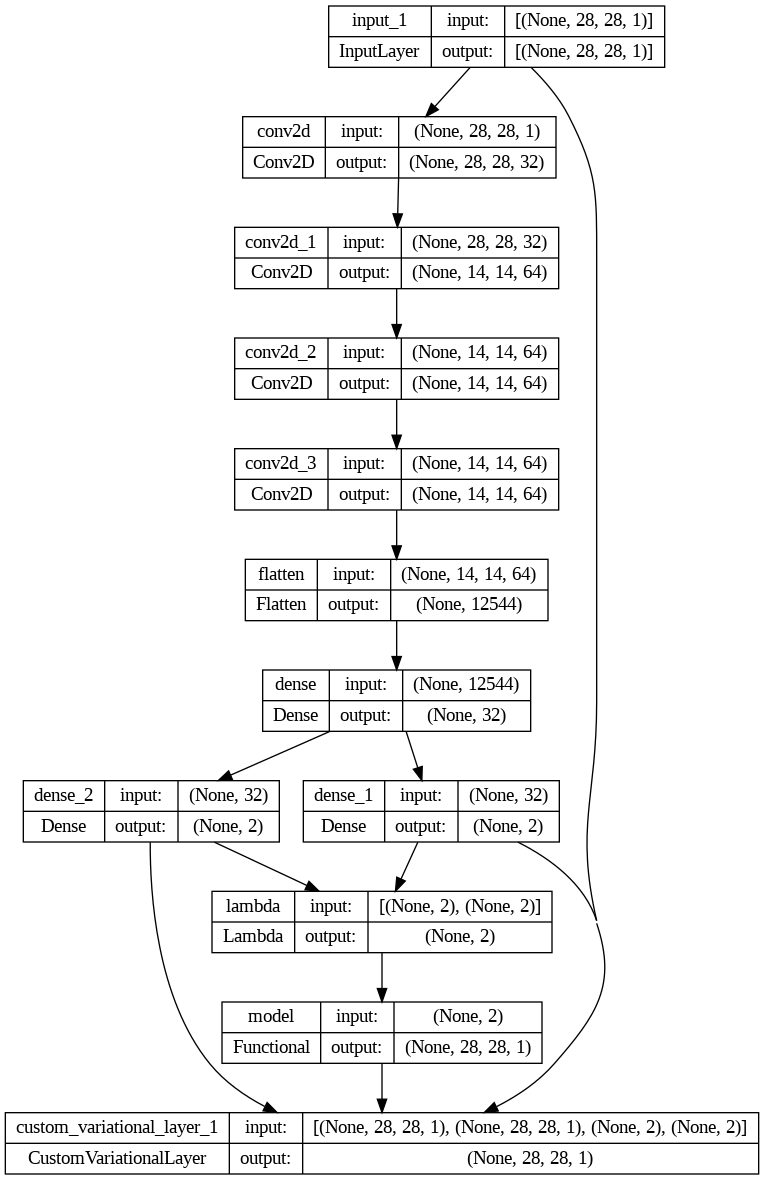

In [17]:
from keras.utils import plot_model
plot_model(vae,
           show_shapes = True,
           show_layer_names = True)

<h1><b>Training Model

In [ ]:
vae.fit(x=X_train,
        y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size)

Epoch 1/10
3750/3750 [==============================] - 29s 5ms/step - loss: 0.1031
Epoch 2/10
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0056
Epoch 3/10
3750/3750 [==============================] - 21s 6ms/step - loss: 0.0056
Epoch 4/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.0056
Epoch 5/10
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0056
Epoch 6/10
3750/3750 [==============================] - 21s 6ms/step - loss: 0.0056
Epoch 7/10
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0056
Epoch 8/10
3750/3750 [==============================] - 21s 6ms/step - loss: 0.0056
Epoch 9/10
3750/3750 [==============================] - 21s 6ms/step - loss: 0.0056
Epoch 10/10
3750/3750 [==============================] - 21s 6ms/step - loss: 0.0056


In [ ]:
# encoder = Model(input_img, z_mu)
# X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
# plt.figure(figsize=(10, 10))
# plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=y_test, cmap='brg')
# plt.grid()
# plt.colorbar()
# plt.show()

In [ ]:
# decoder = tf.keras.models.load_model('/content/drive/MyDrive/prescient/Auto Encoders/VAE/decoder1.h')

In [ ]:
num_samples = 10

latent_samples = np.random.normal(size=(num_samples, 2))

decoded_samples = decoder.predict(latent_samples)

1/1 [==============================] - 0s 27ms/step


In [ ]:
latent_samples

array([[-0.05639323,  1.04022402],
       [ 0.2019025 , -0.10676505],
       [-0.08172253,  0.1591339 ],
       [ 1.5961251 , -1.31809508],
       [-0.8607025 ,  0.45626643],
       [ 0.65160566, -0.36426001],
       [ 0.24456024,  0.06650607],
       [-0.15857571, -0.40195143],
       [-0.57293492,  1.38176281],
       [-0.89852651,  0.66030045]])

In [ ]:
decoded_samples;

In [ ]:
import matplotlib.pyplot as plt

def display(img):
  img = np.where(generated_image>0, 1, 0)
  plt.figure(figsize=(2, 2))
  plt.imshow(img.reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.show()

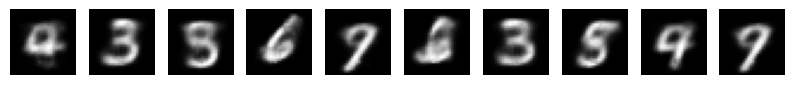

In [ ]:
import matplotlib.pyplot as plt

def display_images(decoded_samples, latent_samples, num_rows=1, num_cols=10):
    plt.figure(figsize=(num_cols, num_rows))
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(decoded_samples[i].reshape(28, 28), cmap='gray')
        # plt.title(f"{latent_samples[i]}")
        plt.axis('off')
    plt.show()

display_images(decoded_samples, latent_samples)


1/1 [==============================] - 0s 38ms/step


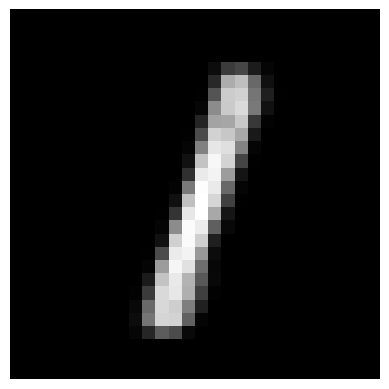

In [ ]:
def generate_digit(decoder, latent_vector):
    latent_vector = np.reshape(latent_vector, (1, -1))

    # Decode the user-defined latent vector
    generated_digit = decoder.predict(latent_vector)

    # Plot the generated digit
    plt.imshow(generated_digit[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.show()

# Generate a new digit
generate_digit(decoder, [-2, -2])

In [ ]:
# encoder.save('/content/drive/MyDrive/prescient/Auto Encoders/VAE/encoder2.h')
# decoder.save('/content/drive/MyDrive/prescient/Auto Encoders/VAE/decoder2.h')